In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
import pickle

In [2]:
#import data and define test and train datasets
test = pd.read_pickle('test.pkl')
train = pd.read_pickle('train.pkl')

selected_features1 = train.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = train.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = train.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_train = selected_features
y_train = train["firm"]

selected_features1 = test.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = test.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = test.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_test = selected_features
y_test = test["firm"]

In [3]:
#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
#hyperparameter tune and fit model
knn = KNeighborsClassifier()
k_range = list(range(1, 30))
weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=k_range, weights=weight_options)
rand = RandomizedSearchCV(knn, param_dist, cv=5, scoring='accuracy', n_iter=10, random_state=42)
rand.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy')

In [5]:
#view best parameters
rand.best_params_

{'weights': 'uniform', 'n_neighbors': 24}

In [6]:
#view accuracy scores - training and test data
print(rand.best_score_)
print(rand.score(X_test, y_test))

0.6954248366013072
0.6710182767624021


In [7]:
#view classification report
y_pred_test = rand.predict(X_test)
result1 = classification_report(y_test, y_pred_test)
print("Classification Report:",)
print(result1)

Classification Report:
              precision    recall  f1-score   support

       Big 4       0.69      0.81      0.75       463
       Other       0.61      0.45      0.52       303

    accuracy                           0.67       766
   macro avg       0.65      0.63      0.64       766
weighted avg       0.66      0.67      0.66       766



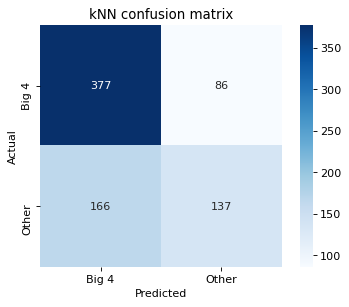

In [8]:
# print confusion matrix for kNN
knn_confusion = confusion_matrix(y_test, y_pred_test)
plt.figure(dpi=80)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Big 4', 'Other'],
           yticklabels=['Big 4', 'Other'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

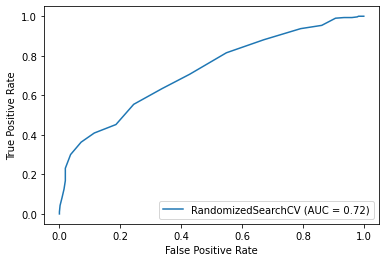

In [9]:
#view ROC curve
metrics.plot_roc_curve(rand, X_test, y_test)
plt.show()

In [11]:
filename = 'knn.pkl'
pickle.dump(rand, open(filename, 'wb'))